In [1]:
# Add autoreload
%load_ext autoreload
%autoreload 2

In [18]:
import os
import sys
sys.path.insert(0, "../")

from src.energy import style_transfer, feature_WCT, total_energy, cluster_style, data_energy, smooth_energy
from src.misc.feature import MultimodalStyleTransfer
from src.models.model import TransferModel

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from maxflow.fastmin import aexpansion_grid

import numpy as np
import copy

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 512 if torch.cuda.is_available() else 128

In [4]:
loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [91]:
style_img = image_loader("../data/images/monnet.png")[:, :3]
content_img = image_loader("../data/images/dance2.png")[:, :3]

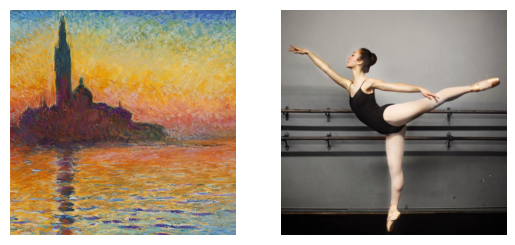

In [92]:
plt.subplot(1, 2, 1)
plt.imshow(style_img[0].cpu().numpy().transpose(1, 2, 0))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(content_img[0].cpu().numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()

In [93]:
n_clusters = 3
alpha = 0.3
gamma = 0.01
lambd = 0.1

model = TransferModel(
    base_model=vgg19(weights=VGG19_Weights.DEFAULT),
    pretrained_weights=None,
    n_clusters=n_clusters,
    alpha=alpha,
    gamma=gamma,
    lambd=lambd,
    mode="style_transfer"#"style_transfer"#"full_pretrain"#
).to(device)

In [94]:
content_features = model.encoder(content_img)
style_img = model.encoder(style_img)

In [95]:
content_features.shape, style_img.shape

(torch.Size([1, 512, 64, 64]), torch.Size([1, 512, 64, 64]))

In [118]:
sample_content_features = content_features[0].cpu().detach().numpy()
sample_style_features = style_img[0].cpu().detach().numpy()

def labeling(content_feat, style_feat, lambd=0.1, k=3):
    cluster_centers, cluster_list = cluster_style(style_feat, k=k)

    data_term = data_energy(content_feat, cluster_centers)  # (height, width, k)
    smooth_term = smooth_energy(cluster_centers, lambd)  # (k, k)
    data_term = data_term.astype(np.double)
    smooth_term = smooth_term.astype(np.double)

    labels = aexpansion_grid(data_term, smooth_term)

    transfered_features = np.zeros(content_feat.shape)
    for i in range(k):
        label = (labels == i).astype(int) # (height, width)

        # Check if the cluster does not have only a single pixel (no need to transfer)
        if cluster_list[i].shape[0] == 1:
            continue
        print(content_feat.shape)
        print(cluster_list[i].shape)
        print(feature_WCT(content_feat, cluster_list[i], label, alpha).shape)
        transfered_features += feature_WCT(content_feat, cluster_list[i], label, alpha)

    transfered_features = torch.from_numpy(transfered_features).float()

    return data_term, smooth_term, labels, transfered_features

In [119]:
all_labels = []
all_transfered_features = []
all_smooth_terms = []
all_data_terms = []
lambdas = [0, 0.001, 0.01, 0.1]

for lambd in lambdas:
    data_term, smooth_term, labels, transfered_features = labeling(sample_content_features, sample_style_features, lambd)
    all_transfered_features.append(transfered_features)
    all_labels.append(labels)
    all_smooth_terms.append(smooth_term)
    all_data_terms.append(data_term)

(512, 64, 64)
(1753, 512)
(512, 64, 64)
(512, 64, 64)
(1612, 512)
(512, 64, 64)
(512, 64, 64)
(731, 512)
(512, 64, 64)
(512, 64, 64)
(2285, 512)
(512, 64, 64)
(512, 64, 64)
(1135, 512)
(512, 64, 64)
(512, 64, 64)
(676, 512)
(512, 64, 64)
(512, 64, 64)
(650, 512)
(512, 64, 64)
(512, 64, 64)
(1149, 512)
(512, 64, 64)
(512, 64, 64)
(2297, 512)
(512, 64, 64)
(512, 64, 64)
(1612, 512)
(512, 64, 64)
(512, 64, 64)
(731, 512)
(512, 64, 64)
(512, 64, 64)
(1753, 512)
(512, 64, 64)


In [98]:
sample_style_features.shape, transfered_features.shape

((512, 64, 64), torch.Size([512, 64, 64]))

Distance array shape :  (3, 64, 64)
Sample content features shape :  (512, 64, 64)
Assignement shape :  (64, 64)


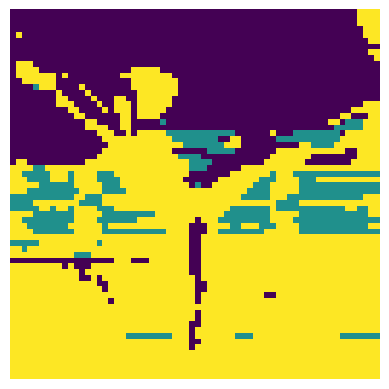

In [102]:
cluster_centers, cluster_list = cluster_style(sample_style_features, k=3)

distance_array = np.zeros((n_clusters,64,64), dtype=np.float32)
print("Distance array shape : ",distance_array.shape)
print("Sample content features shape : ",sample_content_features.shape)

for i, cluster_center in enumerate(cluster_centers):
    cluster = cluster_center
    cluster = np.repeat(cluster_center[:, np.newaxis, np.newaxis], sample_content_features.shape[1], axis=1)
    cluster = np.repeat(cluster, sample_content_features.shape[1], axis=2)
    distances = np.linalg.norm(sample_content_features - cluster, axis=0)
    distance_array[i] = distances
distances = distance_array.transpose(1,2,0)
greedy_assignments = np.argmin(distances,axis=2)
print("Assignement shape : ",greedy_assignments.shape)
plt.imshow(greedy_assignments)
plt.axis('off')
plt.show()

In [103]:
all_smooth_terms

[array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 array([[0.   , 0.001, 0.001],
        [0.001, 0.   , 0.001],
        [0.001, 0.001, 0.   ]]),
 array([[0.  , 0.01, 0.01],
        [0.01, 0.  , 0.01],
        [0.01, 0.01, 0.  ]]),
 array([[0. , 0.1, 0.1],
        [0.1, 0. , 0.1],
        [0.1, 0.1, 0. ]])]

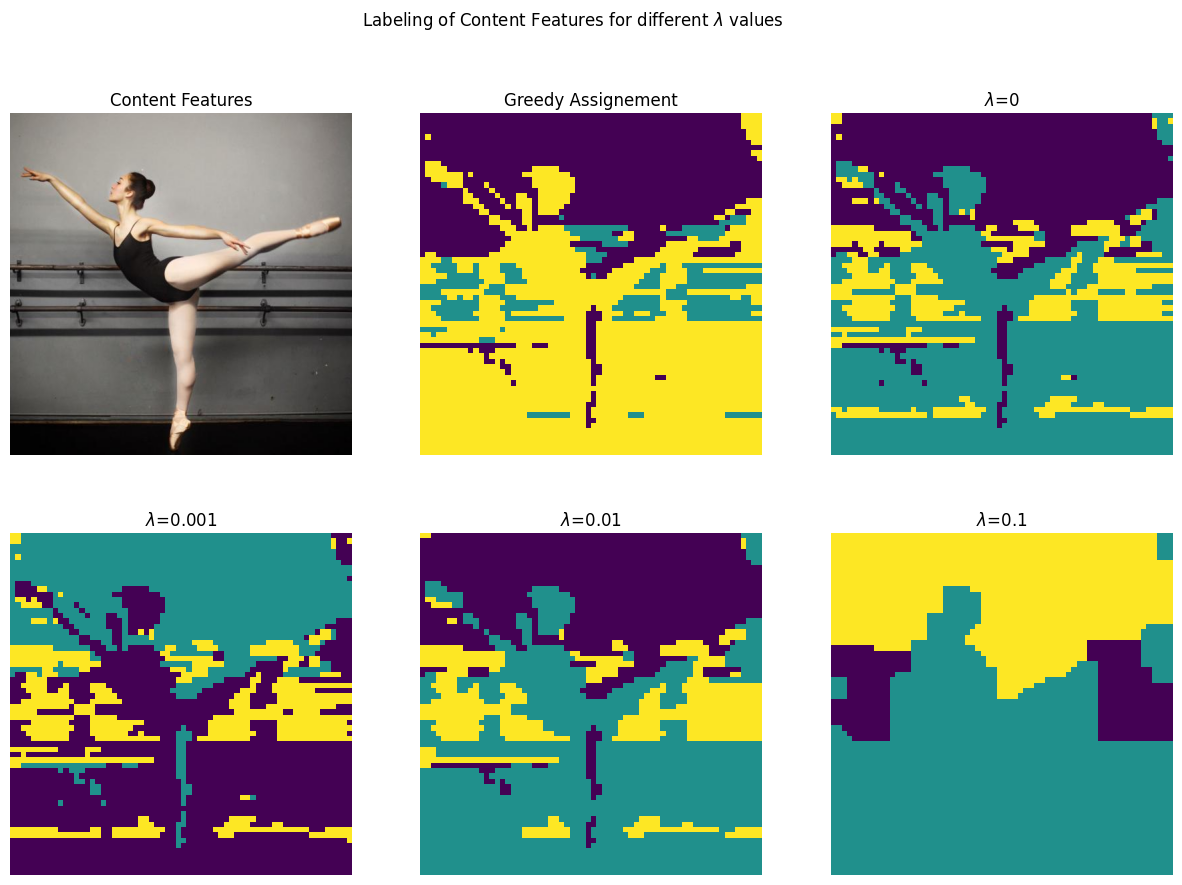

In [104]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i, ax in enumerate(axs.flatten()):
    if i > 1:
        ax.imshow(all_labels[i-2])
        ax.axis('off')
        ax.set_title(f"$\lambda$={lambdas[i-2]}")
    elif i == 1:
        ax.imshow(greedy_assignments)
        ax.axis('off')
        ax.set_title("Greedy Assignement")
    else:
        ax.imshow(content_img[0].cpu().numpy().transpose(1, 2, 0))
        ax.axis('off')
        ax.set_title("Content Features")
plt.suptitle("Labeling of Content Features for different $\lambda$ values")
plt.show()

In [88]:
# Shape of the transfered features
print("Transfered features shape : ", transfered_features.shape)

Transfered features shape :  torch.Size([512, 64, 64])


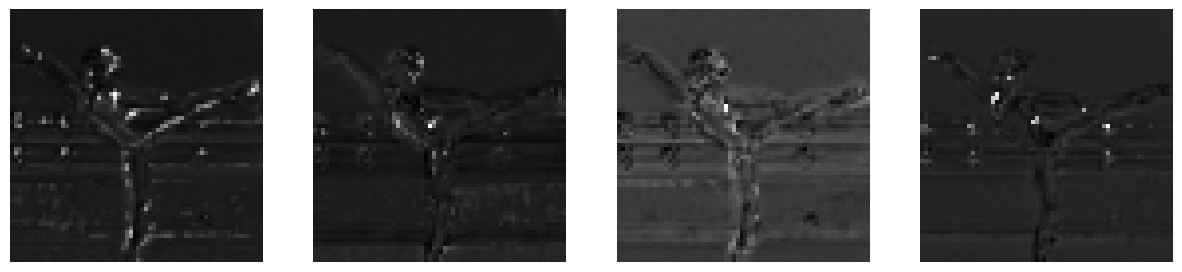

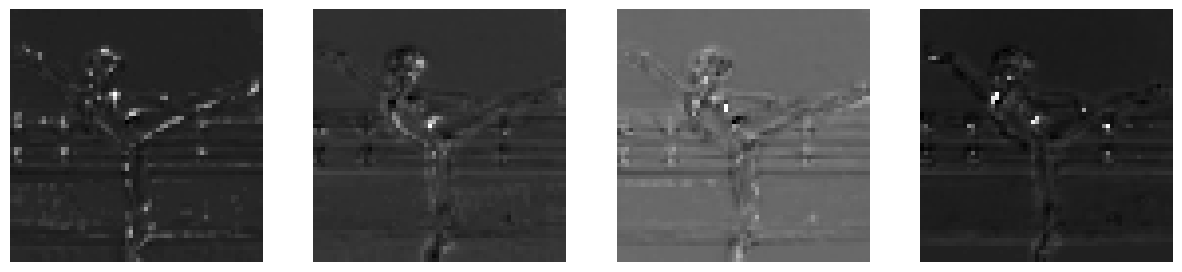

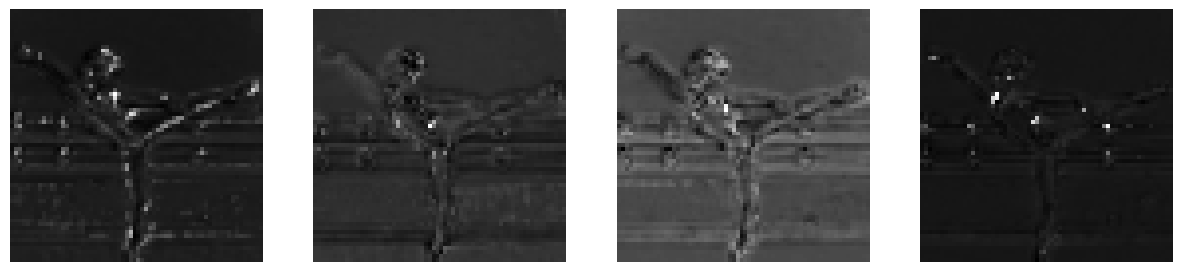

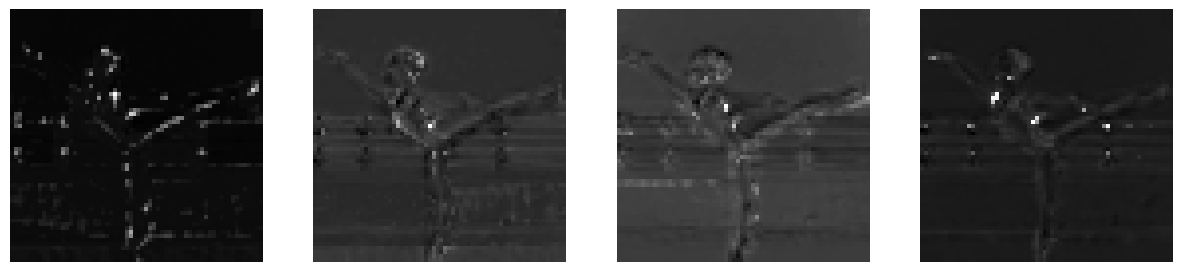

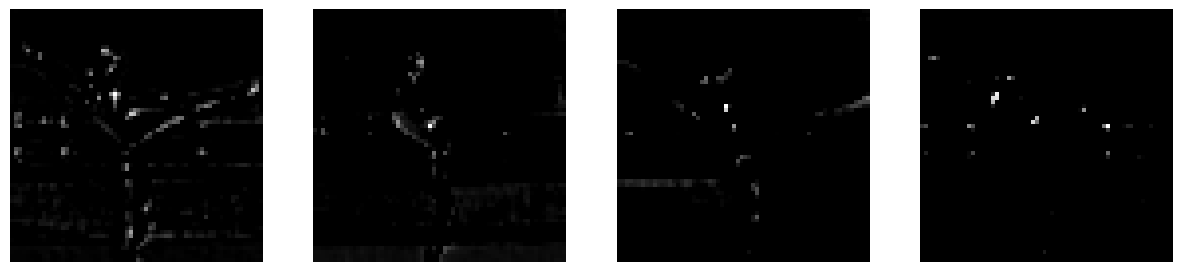

In [115]:
# Plot some of the transfered features at random
n_features_square = 2
for j in range(len(all_transfered_features)):
    fig, axs = plt.subplots(1, n_features_square**2, figsize=(15, 15))
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(all_transfered_features[j][i].cpu().numpy(), cmap='gray')
        ax.axis('off')
    # plt.suptitle(f"Transfered features for $\lambda$={lambdas[j]}")
    plt.show()

fig, axs = plt.subplots(1, n_features_square**2, figsize=(15, 15))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(sample_content_features[i], cmap='gray')
    ax.axis('off')